In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, chisquare
import scipy.stats  as stats
import nltk
from nltk.stem.snowball import FrenchStemmer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from IPython.display import display, Markdown, Image
import urllib.request
plt.style.use('fivethirtyeight')
pd.options.display.max_columns = None
pd.options.display.max_rows = 200

### fonctions

In [2]:
def retraitement (Colonne): #retraite les données textuelles d'une serie Pandas et retourne une serie

    #Normalisation
    
    Accent = ['é', 'è', 'ê','ù', 'û', 'ç', 'ô', 'î', 'ï', 'â','ó']
    SansAccent = ['e', 'e', 'e','u', 'u', 'c', 'o', 'i', 'i', 'a','o']

    Colonne2=Colonne.fillna('').str.lower()
    Colonne2=Colonne2.str.strip()
    for i in range(len(Accent)):    # remplacement des caractères avec accent par les caractères sans accent correspondant
        Colonne2=Colonne2.str.replace(Accent[i],SansAccent[i])
    Colonne2=Colonne2.astype('str')
    
    #Tokenisation
    
    tokenizer = nltk.RegexpTokenizer(r'\w*')
    Colonne2=Colonne2.apply(lambda x : tokenizer.tokenize(x) if pd.notnull(x) else x)

    #Supression des stop words
    
    sw=set()
    sw.update(tuple(nltk.corpus.stopwords.words('french')))
    Colonne2=[[mot for mot in nom if mot not in list(sw)] for nom in Colonne2]

    #racinisation
    stemmer = FrenchStemmer()
    Colonne2= [[stemmer.stem(mot) for mot in nom] for nom in Colonne2]
    
    return (Colonne2)

In [3]:
def proport(ser): # prend une serie numérique de pandas et retourne la proportion de chaque valeur dans la somme
    
    somme = ser.sum()
    ser2=ser.transform (lambda x : x*100/somme)
    
    return (ser2)

In [4]:
def chi2 (df,col1,col2):  #prend 2 colonnes d'un dataframe et effectue un test chi2 d'indépendance
 #   return
    
    TabCon=df[[col1,col2]]
    TabCon2=TabCon.dropna()
    TabCon3=TabCon2.pivot_table(index=col1, columns=col2, aggfunc=len)

    TabCon3.loc['tot1']=TabCon3.iloc[:-1].sum(axis=0)
    TabCon3['tot2']=TabCon3.iloc[:,:-1].sum(axis=1)
    Nova=TabCon3[['tot2']]
    Nutr=TabCon3.loc[['tot1']]
    total=TabCon3.iloc[-1,-1]
    TabTheo=Nova.dot(Nutr.to_numpy())/total
    TabTheo.columns=TabCon3.columns
    TabTheo2=TabTheo.iloc[:-1,:-1]
    TabCon4=TabCon3.iloc[:-1,:-1]
    TabCon4=TabCon4.to_numpy().reshape(1,-1)
    TabTheo2=TabTheo2.to_numpy().reshape(1,-1)
    TabTot=((TabCon3-TabTheo)**2)/TabTheo
    TabTot = TabTot.iloc[:-1,:-1]

    return(chisquare(TabCon4[0],TabTheo2[0]), TabTheo, TabCon3, TabTot)
    

In [5]:
def nettoy(x):  # pour le nettoyage de la colonne categorie principale
    if pd.notnull(x):
        if len(x)>3:
            if x[2]==':':
                x=x.replace('-',' ')
                return(x[3:])
            else :
                return(x)
        else :
            return(x)
    else :
        return(x)
            

In [6]:
def Classif(cat,gro):
    if np.logical_and(pd.notnull(cat),pd.notnull(gro)):
        sta='Les deux'
    elif (pd.isnull(cat) & pd.isnull(gro)):
        sta='Aucun'
    elif (pd.isnull(cat) & pd.notnull(gro)):
        sta='PNNS uniquement'
    elif (pd.notnull(cat) & pd.isnull(gro)):
        sta='Catégorie uniquement'
    return sta

### loading du fichier

In [7]:
base = pd.read_csv('openfoodfacts.csv', sep='\t')

/home/olivier/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (0,8,13,22,23,27,28,29,31,52,55,64,66) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [8]:
base.describe(include='all')

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,abbreviated_product_name,generic_name,quantity,packaging,packaging_tags,packaging_text,brands,brands_tags,categories,categories_tags,categories_en,origins,origins_tags,origins_en,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_en,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,allergens,allergens_en,traces,traces_tags,traces_en,serving_size,serving_quantity,no_nutriments,additives_n,additives,additives_tags,additives_en,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,ingredients_that_may_be_from_palm_oil_tags,nutriscore_score,nutriscore_grade,nova_group,pnns_groups_1,pnns_groups_2,states,states_tags,states_en,brand_owner,ecoscore_score_fr,ecoscore_grade_fr,main_category,main_category_en,image_url,image_small_url,image_ingredients_url,image_ingredients_small_url,image_nutrition_url,image_nutrition_small_url,energy-kj_100g,energy-kcal_100g,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,-butyric-acid_100g,-caproic-acid_100g,-caprylic-acid_100g,-capric-acid_100g,-lauric-acid_100g,-myristic-acid_100g,-palmitic-acid_100g,-stearic-acid_100g,-arachidic-acid_100g,-behenic-acid_100g,-lignoceric-acid_100g,-cerotic-acid_100g,-montanic-acid_100g,-melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,-alpha-linolenic-acid_100g,-eicosapentaenoic-acid_100g,-docosahexaenoic-acid_100g,omega-6-fat_100g,-linoleic-acid_100g,-arachidonic-acid_100g,-gamma-linolenic-acid_100g,-dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,-oleic-acid_100g,-elaidic-acid_100g,-gondoic-acid_100g,-mead-acid_100g,-erucic-acid_100g,-nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,-sucrose_100g,-glucose_100g,-fructose_100g,-lactose_100g,-maltose_100g,-maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,soluble-fiber_100g,insoluble-fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-dried_100g,fruits-vegetables-nuts-estimate_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
count,9.999990e+05,999999,999998,9.999990e+05,999999,9.999990e+05,999999,968925,4403,63126,200810,137714,137700,3815,509354,509323,564984,564981,564981,43500,43449,43449,56376,56340,193237,193235,193235,76399,76368,59339,0.0,63911,74200,133228,997597,997596,997596,488957,127175,0.0,47139,58453,58453,386284,3.834610e+05,0.0,488958.000000,0.0,297918,297918,488958.000000,0.0,5536,488958.000000,0.0,27118,446764.000000,446764,442788.000000,999955,999955,999999,999999,999999,284874,5.000000,5,564981,564981,643622,643622,319601,319601,413076,413076,5.975500e+04,8.053890e+05,8.236960e+05,907.000000,820179.000000,782313.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43706.000000,43700.000000,1048.000000,0.0,0.0,0.0,252.000000,0.0,0.0,0.0,0.0,37.000000,0.0,0.0,0.0,0.0,0.0,0.0,258470.000000,262328.000000,8

In [9]:
baseM=base.copy()

### Selection des colonnes utiles et changement des noms de colonnes pour plus de clarté

In [10]:
colonnes_utiles=['code','product_name','categories','labels_en','stores',\
'countries_en', 'brands','main_category_en','image_small_url',\
'nutriscore_score','nutriscore_grade','nova_group','pnns_groups_1',\
'pnns_groups_2','energy-kcal_100g','saturated-fat_100g','sugars_100g','proteins_100g',\
'fiber_100g','fruits-vegetables-nuts-estimate_100g','fat_100g','carbohydrates_100g', 'salt_100g']
baseM=baseM.loc[:,np.isin(baseM.columns, colonnes_utiles)]

baseM['code']=baseM['code'].astype('str') # force le format str pour la colonne code
baseM.loc[pd.notnull(baseM['nutriscore_grade']),['nutriscore_grade']]=baseM['nutriscore_grade'].str.upper()# met en majuscule
baseM.loc[pd.notnull(baseM['energy-kcal_100g']),'energy-kcal_100g']=baseM.loc[pd.notnull(baseM['energy-kcal_100g']),'energy-kcal_100g'].astype('int')

for i in ['saturated-fat_100g','sugars_100g','proteins_100g','fiber_100g','fruits-vegetables-nuts-estimate_100g',\
          'fat_100g','carbohydrates_100g', 'salt_100g']:
    baseM[i]=round(baseM[i],2)

NouvCol = {'code':'code','product_name':'Nom Produit','image_small_url':'Image','labels_en':'Label','brands':'Marque','main_category_en':'Categorie principale',\
'countries_en':'Pays', 'categories':'Categories', 'allergens':'Allergenes','traces_en':'Traces','stores':'Point de vente',\
'nutriscore_score':'Nutri-Score','nutriscore_grade':'Note de Nutri-Score','nova_group': 'NOVA','pnns_groups_1' :'Groupe PNNS',\
'pnns_groups_2':'Sous-groupe PNNS','main_category_en':'Categorie principale','energy-kcal_100g':'Energie',\
'saturated-fat_100g':'Graisses saturees','sugars_100g':'Sucres','proteins_100g':'Proteines',\
'sodium_100g':'Sodium','fruits-vegetables-nuts-estimate_100g':'Fruits/Legumes/Noix','fat_100g':'Graisses',\
'carbohydrates_100g':'Glucides', 'salt_100g':'Sel','fiber_100g':'Fibres'}

baseM.columns=baseM.columns.map(NouvCol)

In [11]:
baseM.head(5)

,code,Nom Produit,Marque,Categories,Label,Point de vente,Pays,Nutri-Score,Note de Nutri-Score,NOVA,Groupe PNNS,Sous-groupe PNNS,Categorie principale,Image,Energie,Graisses,Graisses saturees,Glucides,Sucres,Fibres,Proteines,Sel,Fruits/Legumes/Noix
0,00000000000000225,jeunes pousses,endives,NaN,NaN,NaN,France,NaN,NaN,NaN,unknown,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00000000000003429145,L.casei,NaN,NaN,NaN,NaN,Spain,NaN,NaN,NaN,unknown,unknown,NaN,https://images.openfoodfacts.org/images/produc...,NaN,1.4,0.90,9.8,9.8,NaN,2.7,0.1,NaN
2,0000000000017,Vitória crackers,NaN,NaN,NaN,NaN,France,NaN,NaN,NaN,unknown,unknown,NaN,https://images.openfoodfacts.org/images/produc...,375.0,7.0,3.08,70.1,15.0,NaN,7.8,1.4,NaN
3,0000000000031,Cacao,NaN,NaN,NaN,NaN,France,NaN,NaN,NaN,unknown,unknown,NaN,https://images.openfoodfacts.org/images/produc...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,000000000003327986,Filetes de pollo empanado,NaN,NaN,NaN,NaN,Spain,NaN,NaN,NaN,unknown,unknown,NaN,https://images.openfoodfacts.org/images/produc...,163.0,1.9,1.00,NaN,NaN,NaN,15.3,1.1,NaN


### calcul du taux de remplissage des colonnes

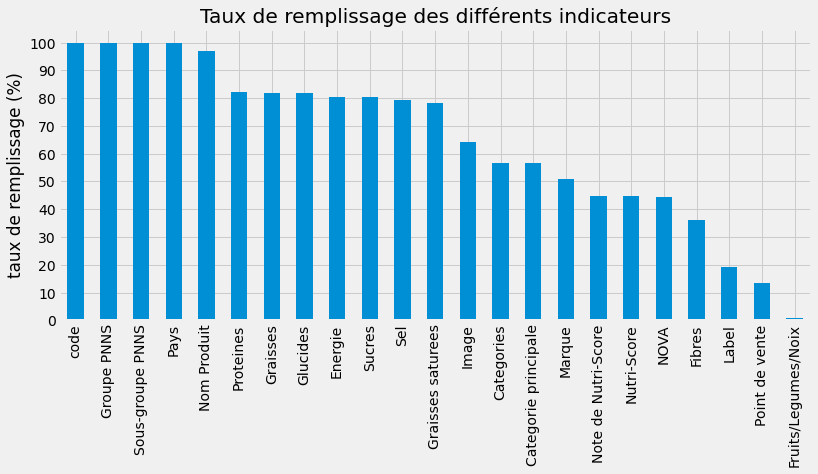

In [12]:
remplissage=baseM.notnull().sum().sort_values(ascending=False)/len(baseM)*100
remplissage.plot(kind='bar', title='Taux de remplissage des différents indicateurs', figsize=[12,5])

plt.ylabel('taux de remplissage (%)')
plt.yticks(np.arange(0,110,10))
plt.grid(True, axis='y')

#### Mapping des noms de catégories de PNNS

In [13]:
Mapping_Pnns1 ={'unknown':np.nan, 'Fat and sauces':'Fat and sauces', 'Composite foods':'Composite foods',
'Sugary snacks':'Sugary snacks','Fruits and vegetables':'Fruits and vegetables','Fish Meat Eggs':'Fish Meat Eggs',
'Milk and dairy products':'Milk and dairy products', 'Cereals and potatoes':'Cereals and potatoes',
'Salty snacks':'Salty snacks','Beverages':'Beverages','sugary-snacks':'Sugary snacks',
'fruits-and-vegetables':'Fruits and vegetables','cereals-and-potatoes':'Cereals and potatoes',
'salty-snacks':'Salty snacks'}

Mapping_Pnns2 ={'unknown':np.nan, 'Alcoholic beverages':'Alcoholic beverages', 'Appetizers':'Appetizers', 
'Artificially sweetened beverages':'Artificially sweetened beverages', 'Biscuits and cakes':'Biscuits and cakes', 
'Bread':'Bread', 'Breakfast cereals':'Breakfast cereals', 'Cereals':'Cereals', 'Cheese':'Cheese', 
'Chocolate products':'Chocolate products', 'Dairy desserts':'Dairy desserts','Dressings and sauces':'Dressings and sauces', 
'Dried fruits':'Dried fruits', 'Eggs':'Eggs', 'Fats':'Fats', 'Fish and seafood':'Fish and seafood', 'Fruit juices':'Fruit juices',
'Fruit nectars':'Fruit nectars','Fruits':'Fruits', 'Ice cream':'Ice cream', 'Legumes':'Legumes', 'Meat':'Meat', 
'Milk and yogurt':'Milk and yogurt', 'Nuts':'Nuts', 'Offals':'Offals', 'One-dish meals':'One-dish meals', 
'Pizza pies and quiche':'Pizza pies and quiches','Pizza pies and quiches':'Pizza pies and quiches', 
'Plant-based milk substitutes':'Plant-based milk substitutes', 'Potatoes':'Potatoes', 'Processed meat':'Processed meat', 
'Salty and fatty products':'Salty and fatty products', 'Sandwiches':'Sandwiches', 'Soups':'Soups', 
'Sweetened beverages':'Sweetened beverages', 'Sweets':'Sweets', 'Teas and herbal teas and coffees':'Teas and herbal teas and coffees',
'Unsweetened beverages':'Unsweetened beverages','Vegetables':'Vegetables', 
'Waters and flavored waters':'Waters and flavored waters', 'cereals':'Cereals', 'fruits':'Fruits', 'legumes':'Legumes',
'nuts':'Nuts', 'pastries':'pastries', 'vegetables':'Vegetables'}

#### Correction de certaines erreurs identifiées

In [14]:
baseM['Groupe PNNS 2']=baseM['Groupe PNNS'].map(Mapping_Pnns1)
baseM['Sous-groupe PNNS 2']=baseM['Sous-groupe PNNS'].map(Mapping_Pnns2)
baseM.loc[baseM['Sous-groupe PNNS 2']=='Pizza pies and quiches','Groupe PNNS']='Composite foods'
baseM.loc[baseM['Sous-groupe PNNS 2']=='Alcoholic beverages','Groupe PNNS']='Beverages'

In [15]:
plt.style.use('default')

In [16]:
baseM.shape

(999999, 25)

### Catégories de colonnes créées pour faciliter l'analyse

In [17]:
Etiquette = ['Energie','Graisses saturees','Graisses','Glucides','Sucres','Proteines', 'Sel']
Etiquette2 = ['Graisses saturees','Graisses','Glucides','Sucres','Proteines', 'Sel']
carac=['Proteines','Sucres','Graisses saturees', 'Fruits/Legumes/Noix','Energie','Fibres','Glucides']
carac2=['Proteines','Sucres','Graisses saturees', 'Fruits/Legumes/Noix','Fibres', 'Glucides', 'Sel']

ValeursInt=set()
for i in carac :
    ValeursInt.add(i)
for i in Etiquette :
    ValeursInt.add(i)
ValeursInt.add('Nutri-Score')

### Selection des lignes dont l'étiquette est remplie

In [18]:
baseM2 = baseM[baseM[Etiquette].notnull().all(axis=1)]
baseM2.shape

(715920, 25)

Text(0.5, 0.98, 'Remplissage des valeurs nutritionnelles ')

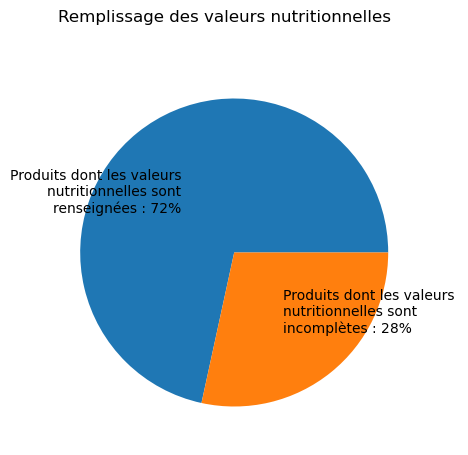

In [19]:
plt.figure(figsize=[6,5])
partEt=baseM2.shape[0]/baseM.shape[0]
partNEt=1-partEt
plt.pie([partEt,partNEt], labels=["Produits dont les valeurs \nnutritionnelles sont \nrenseignées : {:.0%} ".format(partEt),\
"Produits dont les valeurs \nnutritionnelles sont \nincomplètes : {:.0%}".format(partNEt)],labeldistance=0.5)
plt.suptitle('Remplissage des valeurs nutritionnelles ')

### Etude du code barre

In [20]:
BaseEAN13=baseM2[baseM2['code'].str.len()==13]  #lignes ne contenant que les codes barre EAN13
Base2=baseM2[np.isin(baseM2.index, BaseEAN13.index, invert=True)] #lignes contenant le reste des enregistrements
Base200=Base2.loc[Base2['code'].str.find('200',0,3)!=-1] # lignes avec un code qui commence par 200 et qui ne soit pas un EAN13
BaseOth=Base2[np.isin(Base2.index, Base200.index, invert=True)] #lignes ni code EAN13 ni code 200

([<matplotlib.patches.Wedge at 0x7ff6beb8e5b0>,
 [Text(0.010367174777798959, 1.0999511451365132, 'Codes EAN13 :50%'),
  Text(-0.024188517159667362, -1.0997340204056691, 'Autres :50%'),
  Text(1.0999131453198285, -0.013822906808694892, 'Code 200 :0%')])

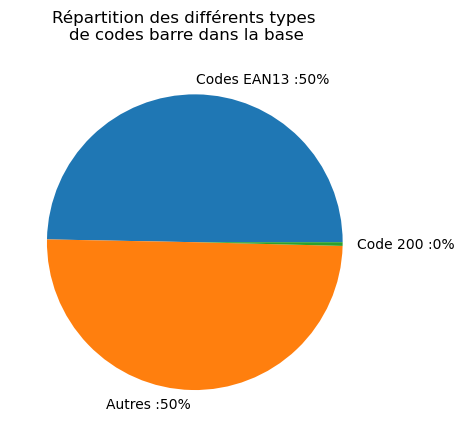

In [21]:
tot=len(baseM2)
pBaseEAN13 = round(len(BaseEAN13)/tot*100,1)
pBase200 = round(len(Base200)/tot*100,1)
pBaseOth = round(len(BaseOth)/tot*100,1)
plt.suptitle('Répartition des différents types \nde codes barre dans la base')
plt.pie([pBaseEAN13, pBaseOth, pBase200], labels=['Codes EAN13 :{}%'.format(int(round(pBaseEAN13,0))), \
 'Autres :{}%'.format(int(round(pBaseOth,0))),'Code 200 :{}%'.format(int(round(pBase200,0)))])

In [22]:
print(len(Base200)+len(BaseOth)+len(BaseEAN13))
print(len(baseM2))

print(baseM2['code'].nunique()/len(baseM2['code'])) #nombre de codes barre uniques dans la base

715920
715920
0.9997918761872835


In [23]:
Occ_Pro=BaseEAN13['Nom Produit'].value_counts()
print(len(Occ_Pro[Occ_Pro==1]))
print(len(Occ_Pro))
print(len(Occ_Pro[Occ_Pro==1])/len(Occ_Pro))
print(Occ_Pro.mean())

208067
238060
0.8740107535915316
1.4913971267747628


In [24]:
baseT=BaseEAN13.copy()

### Produits aux valeurs nutritionnelles abérrantes 

#### Produits dont une valeur nutritionnelle est supérieure à 100g

In [25]:
baseOutliers=baseT.loc[(baseT[carac2]>100).any(axis=1),:]
baseOutliers.shape

(124, 25)

In [26]:
baseT=baseT[np.isin(baseT.index, baseOutliers.index, invert=True)]

#### Produits dont l'energie pour 100 gr est supérieure à 900 kcal

In [27]:
baseOutliers2=baseT.loc[baseT['Energie']>900]
baseOutliers2.shape

(1352, 25)

In [28]:
baseT=baseT[np.isin(baseT.index, baseOutliers2.index, invert=True)]

#### Produits dont la somme Glucides Graisses Proteines Sel Fibres dépasse les 100g

In [29]:
baseOutliers3=baseT.loc[baseT[['Glucides', 'Graisses', 'Proteines','Sel','Fibres']].sum(axis=1)>100]
baseOutliers3.shape

(8200, 25)

In [30]:
baseT=baseT[np.isin(baseT.index, baseOutliers3.index, invert=True)]
Outl = len(baseOutliers)+len(baseOutliers2)+len(baseOutliers3)
Vali = len(baseT)

([<matplotlib.patches.Wedge at 0x7ff688092490>,
 [Text(-1.0960451687281054, 0.09319328359800876, 'Produits valides :97%'),
  Text(1.096045183452179, -0.09319311042818365, 'Produits aux \nvaleurs \nabérrantes :3%')])

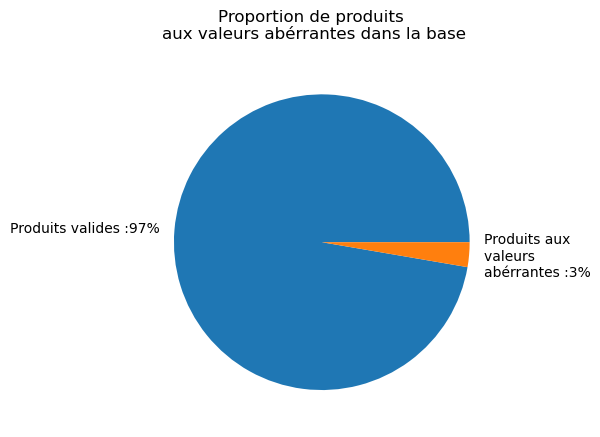

In [31]:
Outl2=round(Outl/(Outl+Vali)*100,1)
Vali2=round(Vali/(Outl+Vali)*100,1)
plt.suptitle('Proportion de produits \naux valeurs abérrantes dans la base')
plt.pie([Vali2,Outl2], labels=['Produits valides :{}%'.format(int(round(Vali2,0))),\
'Produits aux \nvaleurs \nabérrantes :{}%'.format(int(round(Outl2,0)))])

Text(0.5, 1.1, 'Les différentes étapes de réduction de la base')

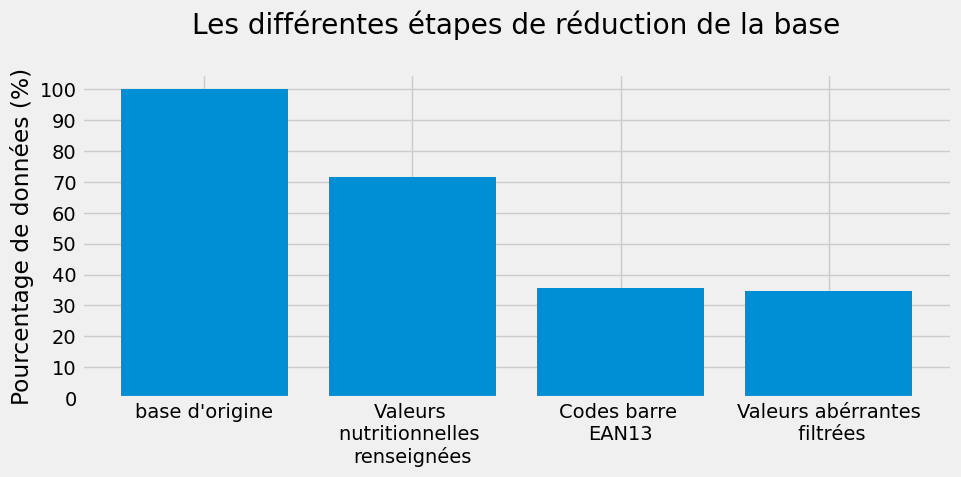

In [32]:
# base - A l'origine
# baseM - copie
# base M2 - Après etiquette filtrée
# baseEAN13 - Après filtre code barre
# baseT - Après filtre valeurs aberrantes

plt.style.use('fivethirtyeight')
plt.figure(figsize=[10,4])
plt.bar([1,2,3,4],[len(base)/len(base)*100,len(baseM2)/len(base)*100,len(BaseEAN13)/len(base)*100,len(baseT)/len(base)*100],\
tick_label=("base d'origine",'Valeurs \nnutritionnelles \nrenseignées','Codes barre \nEAN13','Valeurs abérrantes\n filtrées'))
plt.ylabel('Pourcentage de données (%)')
plt.yticks(np.linspace(0,100,11))
plt.title('Les différentes étapes de réduction de la base', y=1.1)

## analyse de la colonne Nom de Produit

In [33]:
Bisnull =baseT['Nom Produit'].isnull().sum()
Bnotnull= baseT['Nom Produit'].notnull().sum()
PNull=round((Bisnull/len(baseT)*100),1)
POk=100-PNull

Text(0.5, 0.98, 'Présence du nom des produits')

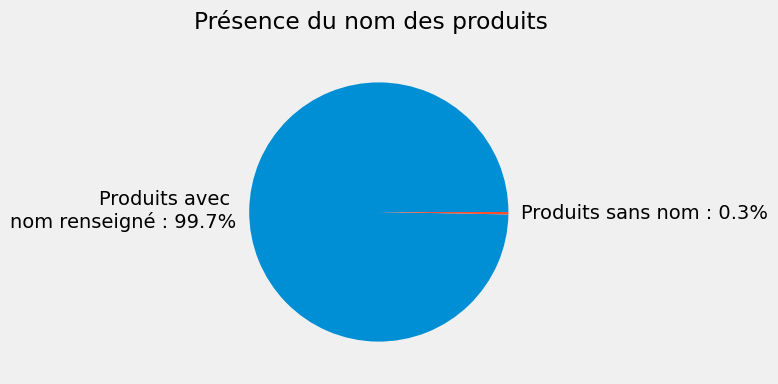

In [34]:
plt.figure(figsize=[5,4])
plt.pie([POk, PNull], labels=['Produits avec \nnom renseigné : {}%'.format(POk),'Produits sans nom : {}%'.format(PNull)])
plt.suptitle('Présence du nom des produits')

### nettoyage de la colonne product_name

In [35]:
NomsNettoyes=retraitement(baseT.loc[:,'Nom Produit'])
NomsNettoyes2=[[mot for mot in nom if mot !='']for nom in NomsNettoyes] #suppression des élements vides

In [36]:
baseT['Nom Produit 2']=NomsNettoyes2
baseT['Nom Produit 2S']=[' '.join(nom) for nom in baseT['Nom Produit 2']]
baseT.loc[baseT['Nom Produit 2S']=='','Nom Produit 2S']=np.nan

In [37]:
baseT[['Nom Produit','Nom Produit 2']].tail(10)

,Nom Produit,Nom Produit 2
999986,Caramel pain d’épice,"[caramel, pain, epic]"
999987,Coulis de caramel,"[coul, caramel]"
999989,Caramel pain d'épices,"[caramel, pain, epic]"
999990,Caramels au pain d'épices,"[caramel, pain, epic]"
999991,Caramel pain d’epices,"[caramel, pain, epic]"
999993,Caramel beurre sale,"[caramel, beurr, sal]"
999995,Coeur de Celtes,"[coeur, celt]"
999996,Coeur de celtes,"[coeur, celt]"
999997,Coulis de caramel beurre salé Salidou,"[coul, caramel, beurr, sal, salidou]"
999998,Coulis De Caramel Au Beurre Sal? 320g,"[coul, caramel, beurr, sal, 320g]"


In [38]:
NomProd=baseT['Nom Produit'].value_counts()
NomProd

Comté                                    751
Emmental                                 430
Filet de poulet                          291
Pollo asado                              266
Jambon à l'ancienne                      265
                                        ... 
Amande grillées a sec et salées            1
Amande grillée                             1
Amandes salees                             1
Amandes grillées a sec et salée            1
Coulis De Caramel Au Beurre Sal? 320g      1
Name: Nom Produit, Length: 231100, dtype: int64

In [39]:
NomProdR=baseT['Nom Produit 2S'].value_counts()
NomProdR

comt                           916
filet poulet                   522
emmental                       487
filet poulet rot               464
jambon ancien                  381
                              ... 
twarog sudeck połtłusty          1
formatg edam                     1
nestl postr blanco               1
worldriderz                      1
coul caramel beurr sal 320g      1
Name: Nom Produit 2S, Length: 184406, dtype: int64

([<matplotlib.axis.YTick at 0x7ff6d8f8b940>,
 [Text(0, 1, '1'),
  Text(0, 10, '10'),
  Text(0, 100, '100'),
  Text(0, 1000, '1000'),
  Text(0, 10000, '10000'),
  Text(0, 10000, '10000'),
  Text(0, 100000, '100000')])

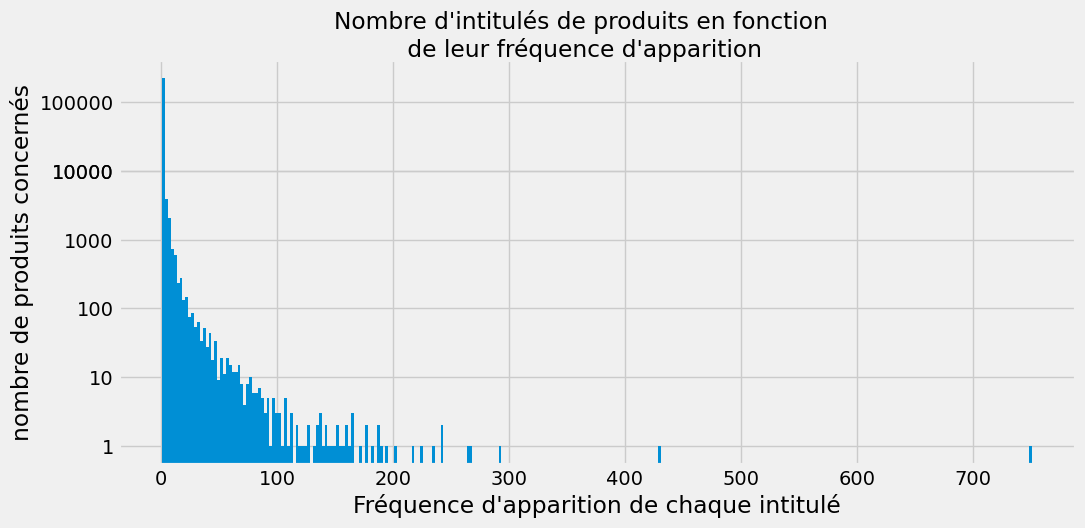

In [40]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=[11,5])
plt.suptitle("Nombre d'intitulés de produits en fonction\n de leur fréquence d'apparition")
plt.hist(NomProd, log=True, bins=300)
plt.ylabel('nombre de produits concernés')
plt.xlabel("Fréquence d'apparition de chaque intitulé")
plt.yticks([1,10,100,1000,10000,10000,100000],[1,10,100,1000,10000,10000,100000])

<ipython-input-41-0230517b0a1e>:4: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.xscale('log', basex=10, subsx=[2, 3, 4, 5, 6, 7, 8, 9])
<ipython-input-41-0230517b0a1e>:4: MatplotlibDeprecationWarning: The 'subsx' parameter of __init__() has been renamed 'subs' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.xscale('log', basex=10, subsx=[2, 3, 4, 5, 6, 7, 8, 9])


Text(0.5, 1.0, "Fréquence d'apparition des noms par quantiles")

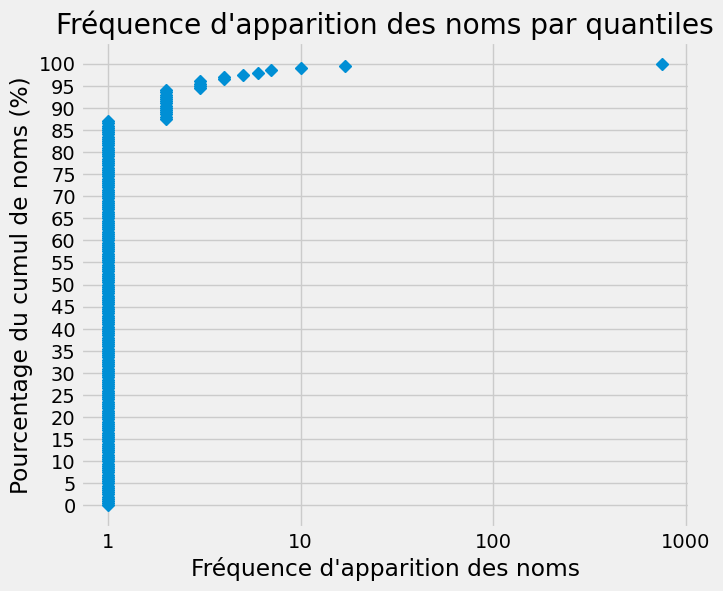

In [41]:

Percen=np.percentile(NomProd,np.linspace(0,100,201))
#np.percentileNomProd
plt.figure(figsize=[7,6])
plt.xscale('log', basex=10, subsx=[2, 3, 4, 5, 6, 7, 8, 9])
plt.plot(Percen,np.linspace(0,100,201) , marker='D',linestyle='none')
plt.yticks(np.linspace(0,100,21))
#plt.xlim([0.8,1000])
plt.xticks([1,10,100,1000],[1,10,100,1000])
plt.ylabel('Pourcentage du cumul de noms (%)')
plt.xlabel("Fréquence d'apparition des noms")
plt.grid('both')
plt.title("Fréquence d'apparition des noms par quantiles")

Text(0.5, 0, "Fréquence d'apparition de chaque produit")

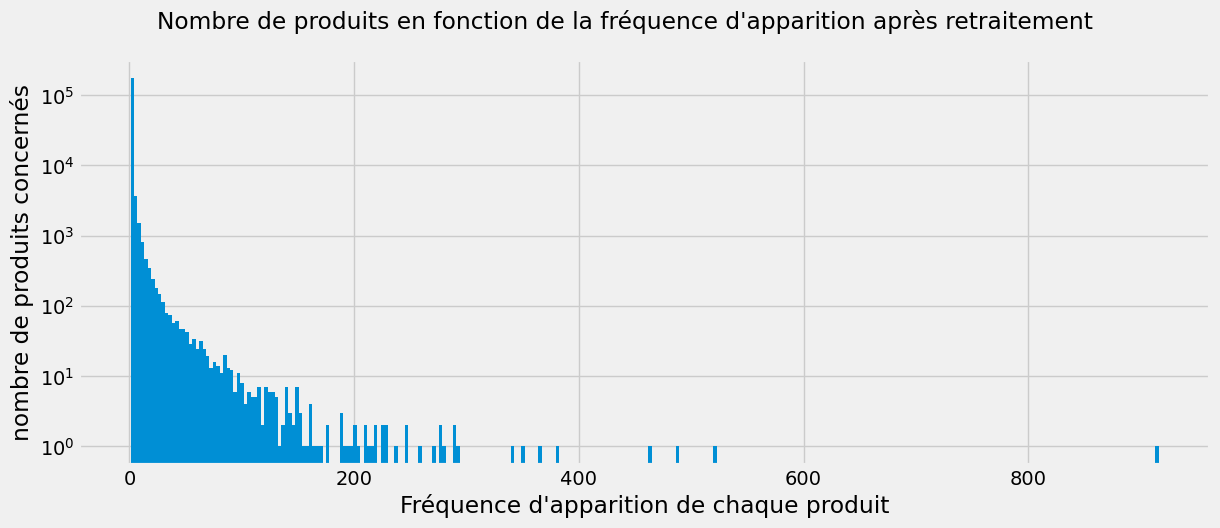

In [42]:
plt.figure(figsize=[13,5])
plt.suptitle("Nombre de produits en fonction de la fréquence d'apparition après retraitement")
plt.hist(NomProdR, log=True, bins=300)
plt.ylabel('nombre de produits concernés')
plt.xlabel("Fréquence d'apparition de chaque produit")

In [43]:
NomProd.describe()

count    231100.000000
mean          1.494543
std           4.204767
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         751.000000
Name: Nom Produit, dtype: float64

In [44]:
NomProdR.describe()

count    184406.000000
mean          1.872602
std           6.635282
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         916.000000
Name: Nom Produit 2S, dtype: float64

In [45]:
len(NomProdR)

184406

In [46]:
(len(NomProd)-len(NomProdR))/len(NomProd)

0.20205106014712246

### Calcul de l'indice de Gini et des courbes de Lorenz

In [47]:
#Produits non retraités
a1=NomProd.to_numpy()    #frequence des produits
b1=np.cumsum(np.sort(a1)) #classé et en cumul   
b1s = b1*100/b1[-1] #chaque valeur est mise en % du total cumulé
biss1=np.linspace(0,100,len(a1)) #première bissectrice
GiniNomProd=(np.trapz(biss1)-np.trapz(b1s))/np.trapz(biss1) # Indice de Gini


#Produits retraités
a2=NomProdR.to_numpy()   #frequence des produits
b2=np.cumsum(np.sort(a2)) #classé et en cumul
b2s = b2*100/b2[-1] #chaque valeur est mise en % du total cumulé
biss2=np.linspace(0,100,len(a2)) #première bissectrice
GiniNomProdR=(np.trapz(biss2)-np.trapz(b2s))/np.trapz(biss2) #Indice de Gini

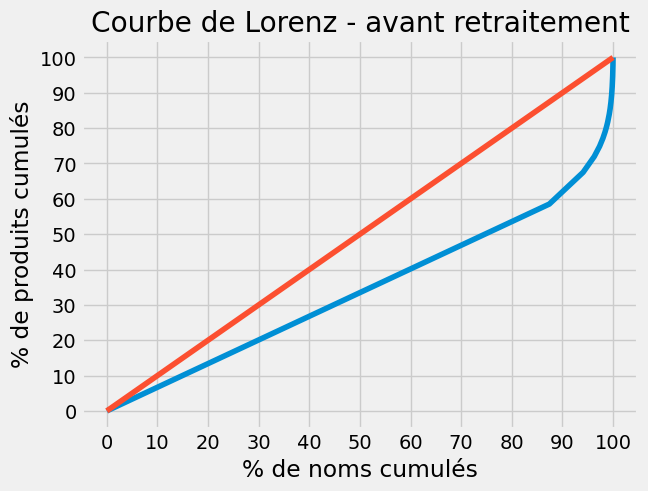

Indice de Gini :  0.32


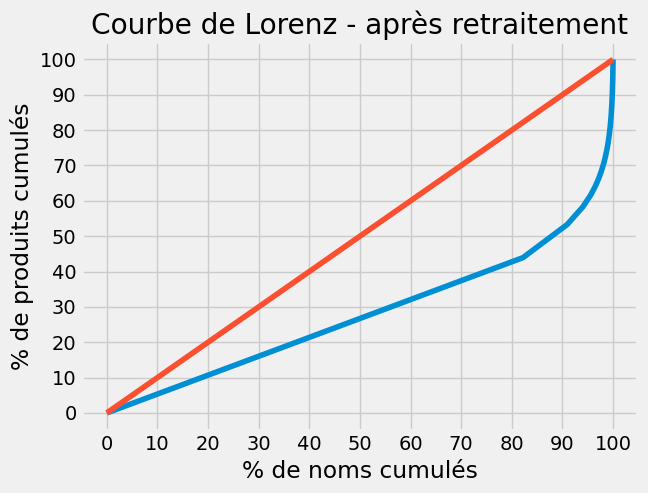

Indice de Gini :  0.44


In [48]:
plt.figure()
plt.plot(biss1,b1s)
plt.plot(biss1,biss1)
plt.title('Courbe de Lorenz - avant retraitement')
plt.ylabel('% de produits cumulés')
plt.xlabel('% de noms cumulés')
plt.xticks(np.linspace(0,100,11))
plt.yticks(np.linspace(0,100,11))
plt.show()

print ('Indice de Gini : ',round(GiniNomProd,2))

plt.figure()
plt.plot(biss2,b2s)
plt.plot(biss2,biss2)
plt.title('Courbe de Lorenz - après retraitement')
plt.ylabel('% de produits cumulés')
plt.xlabel('% de noms cumulés')
plt.xticks(np.linspace(0,100,11))
plt.yticks(np.linspace(0,100,11))
plt.show()

print ('Indice de Gini : ',round(GiniNomProdR,2))

In [49]:
(NomProd==1).mean()

0.8735958459541324

In [50]:
(NomProdR==1).mean()

0.8214971313297832

In [51]:
(len(NomProdR)-len(NomProd))/len(NomProd) # pourcentage de baisse de libellés uniques

-0.20205106014712246

### ECDF

<ipython-input-52-f0a5aa7019fb>:14: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.xscale('log', basex=10)
<ipython-input-52-f0a5aa7019fb>:26: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.xscale('log', basex=10)


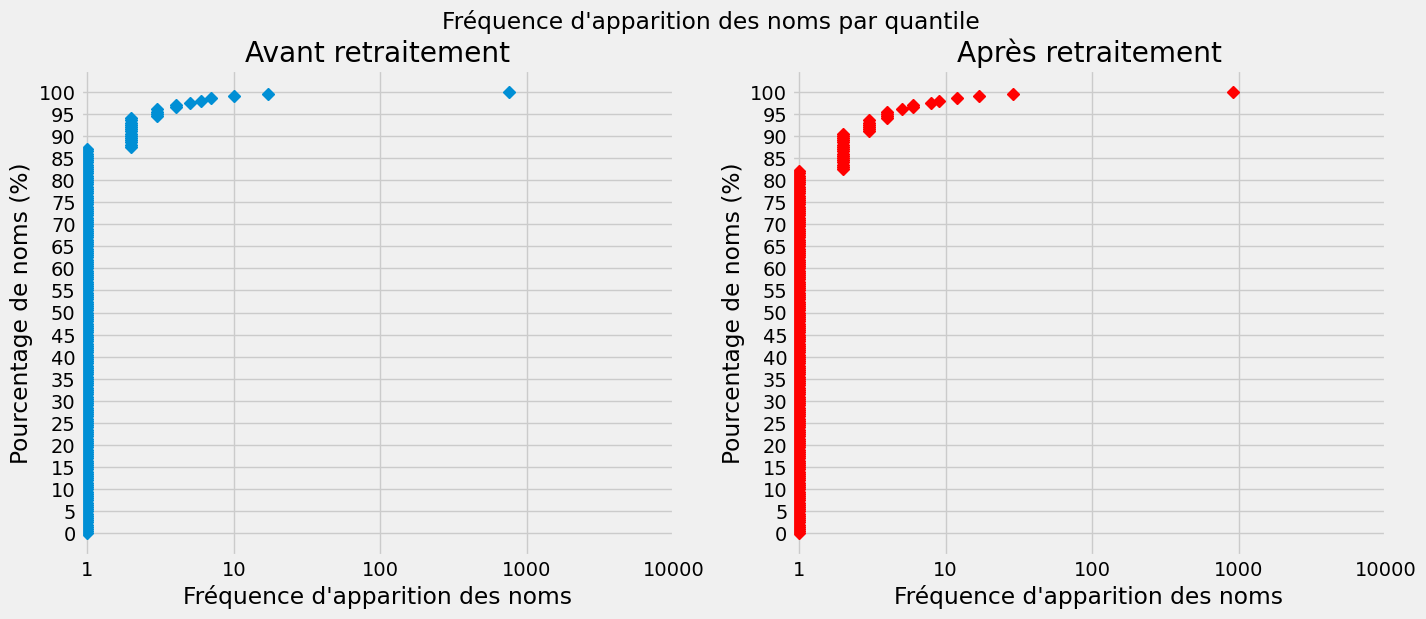

In [52]:
Avant=np.percentile(NomProd,np.linspace(0,100,201))
Apres=np.percentile(NomProdR,np.linspace(0,100,201))
plt.style.use('fivethirtyeight')

plt.subplots(figsize=[15,6])
plt.sharey='row'
plt.suptitle("Fréquence d'apparition des noms par quantile")
plt.subplot(121)
plt.plot(Avant,np.linspace(0,100,201) , marker='D',linestyle='none', label='Avant retraitement')
plt.yticks(np.linspace(0,100,21))
plt.ylabel('Pourcentage de noms (%)')
plt.xlabel("Fréquence d'apparition des noms")
plt.title("Avant retraitement")
plt.xscale('log', basex=10)
plt.xticks([1,10,100,1000,10000],[1,10,100,1000,10000])

plt.xlim(0.9,10000)
plt.grid('y')

plt.subplot(122)
plt.plot(Apres,np.linspace(0,100,201) , marker='D',linestyle='none', label='Après retraitement', color='r')
plt.yticks(np.linspace(0,100,21))
plt.ylabel('Pourcentage de noms (%)')
plt.xlabel("Fréquence d'apparition des noms")
plt.title("Après retraitement")
plt.xscale('log', basex=10)
plt.xticks([1,10,100,1000,10000],[1,10,100,1000,10000])

plt.xlim(0.9,10000)
plt.grid('y')

#### Retraitement de la catégorie principale

#### Avant nettoyage

In [53]:
baseT['Categorie principale'].value_counts().head(100)

Snacks                               3289
Cheeses                              2490
White hams                           2190
Sweetened beverages                  2077
Sauces                               1949
Biscuits                             1786
Labeled-cheeses                      1641
Beverages                            1603
Chicken breasts                      1591
Confectioneries                      1459
Breads                               1211
Frozen foods                         1176
Frozen desserts                      1091
Cakes                                1040
Smoked salmons                        957
Prepared meats                        897
Dry sausage                           884
Cereals and their products            882
Chipolatas                            809
Yogurts                               804
Pork roasts                           783
Unsweetened beverages                 740
Dips                                  733
Dark chocolates                   

#### Après nettoyage

In [54]:
baseT['Categorie principale'].apply(nettoy).value_counts().head(100)

Snacks                               3289
Cheeses                              2490
White hams                           2190
Sweetened beverages                  2077
Sauces                               1949
Biscuits                             1786
Labeled-cheeses                      1641
Beverages                            1603
Chicken breasts                      1591
Confectioneries                      1459
Breads                               1211
Frozen foods                         1176
Frozen desserts                      1091
Cakes                                1040
Smoked salmons                        957
Prepared meats                        897
Dry sausage                           884
Cereals and their products            882
Chipolatas                            809
Yogurts                               804
Pork roasts                           783
Unsweetened beverages                 740
Dips                                  733
Dark chocolates                   

In [55]:
baseT['Categorie principale 2']=baseT['Categorie principale'].apply(nettoy)

### Enregistrement de la base nettoyée pour l'utiliser dans le notebook suivant

In [56]:
baseT.to_csv('BaseRetraiteeV1.csv')